# Node2Vec TF2.0

## Codebase

In [ ]:
import itertools
import math
import random

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from tqdm import trange

from gensim.models import Word2Vec

In [ ]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

In [ ]:
def create_alias_table(area_ratio):
    """
    :param area_ratio: sum(area_ratio)=1
    :return: accept,alias
    """
    l = len(area_ratio)
    accept, alias = [0] * l, [0] * l
    small, large = [], []
    area_ratio_ = np.array(area_ratio) * l
    for i, prob in enumerate(area_ratio_):
        if prob < 1.0:
            small.append(i)
        else:
            large.append(i)

    while small and large:
        small_idx, large_idx = small.pop(), large.pop()
        accept[small_idx] = area_ratio_[small_idx]
        alias[small_idx] = large_idx
        area_ratio_[large_idx] = area_ratio_[large_idx] - \
            (1 - area_ratio_[small_idx])
        if area_ratio_[large_idx] < 1.0:
            small.append(large_idx)
        else:
            large.append(large_idx)

    while large:
        large_idx = large.pop()
        accept[large_idx] = 1
        
    while small:
        small_idx = small.pop()
        accept[small_idx] = 1

    return accept, alias

In [ ]:
def alias_sample(accept, alias):
    """
    :param accept:
    :param alias:
    :return: sample index
    """
    N = len(accept)
    i = int(np.random.random()*N)
    r = np.random.random()
    if r < accept[i]:
        return i
    else:
        return alias[i]

In [ ]:
class RandomWalker:
    def __init__(self, G, p=1, q=1, use_rejection_sampling=0):
        """
        :param G:
        :param p: Return parameter,controls the likelihood of immediately revisiting a node in the walk.
        :param q: In-out parameter,allows the search to differentiate between “inward” and “outward” nodes
        :param use_rejection_sampling: Whether to use the rejection sampling strategy in node2vec.
        """
        self.G = G
        self.p = p
        self.q = q
        self.use_rejection_sampling = use_rejection_sampling

    def deepwalk_walk(self, walk_length, start_node):

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(self.G.neighbors(cur))
            if len(cur_nbrs) > 0:
                walk.append(random.choice(cur_nbrs))
            else:
                break
        return walk

    def node2vec_walk(self, walk_length, start_node):

        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(
                        cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    edge = (prev, cur)
                    next_node = cur_nbrs[alias_sample(alias_edges[edge][0],
                                                      alias_edges[edge][1])]
                    walk.append(next_node)
            else:
                break

        return walk

    def node2vec_walk2(self, walk_length, start_node):
        """
        Reference:
        KnightKing: A Fast Distributed Graph Random Walk Engine
        http://madsys.cs.tsinghua.edu.cn/publications/SOSP19-yang.pdf
        """

        def rejection_sample(inv_p, inv_q, nbrs_num):
            upper_bound = max(1.0, max(inv_p, inv_q))
            lower_bound = min(1.0, min(inv_p, inv_q))
            shatter = 0
            second_upper_bound = max(1.0, inv_q)
            if (inv_p > second_upper_bound):
                shatter = second_upper_bound / nbrs_num
                upper_bound = second_upper_bound + shatter
            return upper_bound, lower_bound, shatter

        G = self.G
        alias_nodes = self.alias_nodes
        inv_p = 1.0 / self.p
        inv_q = 1.0 / self.q
        walk = [start_node]
        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = list(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(
                        cur_nbrs[alias_sample(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    upper_bound, lower_bound, shatter = rejection_sample(
                        inv_p, inv_q, len(cur_nbrs))
                    prev = walk[-2]
                    prev_nbrs = set(G.neighbors(prev))
                    while True:
                        prob = random.random() * upper_bound
                        if (prob + shatter >= upper_bound):
                            next_node = prev
                            break
                        next_node = cur_nbrs[alias_sample(
                            alias_nodes[cur][0], alias_nodes[cur][1])]
                        if (prob < lower_bound):
                            break
                        if (prob < inv_p and next_node == prev):
                            break
                        _prob = 1.0 if next_node in prev_nbrs else inv_q
                        if (prob < _prob):
                            break
                    walk.append(next_node)
            else:
                break
        return walk

    def simulate_walks(self, num_walks, walk_length, workers=1, verbose=0):

        G = self.G

        nodes = list(G.nodes())

        results = Parallel(n_jobs=workers, verbose=verbose, )(
            delayed(self._simulate_walks)(nodes, num, walk_length) for num in
            partition_num(num_walks, workers))

        walks = list(itertools.chain(*results))

        return walks

    def _simulate_walks(self, nodes, num_walks, walk_length,):
        walks = []
        for _ in range(num_walks):
            random.shuffle(nodes)
            for v in nodes:
                if self.p == 1 and self.q == 1:
                    walks.append(self.deepwalk_walk(
                        walk_length=walk_length, start_node=v))
                elif self.use_rejection_sampling:
                    walks.append(self.node2vec_walk2(
                        walk_length=walk_length, start_node=v))
                else:
                    walks.append(self.node2vec_walk(
                        walk_length=walk_length, start_node=v))
        return walks

    def get_alias_edge(self, t, v):
        """
        compute unnormalized transition probability between nodes v and its neighbors give the previous visited node t.
        :param t:
        :param v:
        :return:
        """
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for x in G.neighbors(v):
            weight = G[v][x].get('weight', 1.0)  # w_vx
            if x == t:  # d_tx == 0
                unnormalized_probs.append(weight/p)
            elif G.has_edge(x, t):  # d_tx == 1
                unnormalized_probs.append(weight)
            else:  # d_tx > 1
                unnormalized_probs.append(weight/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs = [
            float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return create_alias_table(normalized_probs)

    def preprocess_transition_probs(self):
        """
        Preprocessing of transition probabilities for guiding the random walks.
        """
        G = self.G
        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr].get('weight', 1.0)
                                  for nbr in G.neighbors(node)]
            norm_const = sum(unnormalized_probs)
            normalized_probs = [
                float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = create_alias_table(normalized_probs)

        if not self.use_rejection_sampling:
            alias_edges = {}

            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                if not G.is_directed():
                    alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
                self.alias_edges = alias_edges

        self.alias_nodes = alias_nodes
        return

In [ ]:
class Node2Vec:

    def __init__(self, graph, walk_length, num_walks, p=1.0, q=1.0, workers=1, use_rejection_sampling=0):

        self.graph = graph
        self._embeddings = {}
        self.walker = RandomWalker(
            graph, p=p, q=q, use_rejection_sampling=use_rejection_sampling)

        print("Preprocess transition probs...")
        self.walker.preprocess_transition_probs()

        self.sentences = self.walker.simulate_walks(
            num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)

    def train(self, embed_size=128, window_size=5, workers=3, iter=5, **kwargs):

        kwargs["sentences"] = self.sentences
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["size"] = embed_size
        kwargs["sg"] = 1
        kwargs["hs"] = 0  # node2vec not use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["iter"] = iter

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs)
        print("Learning embedding vectors done!")

        self.w2v_model = model

        return model

    def get_embeddings(self,):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

## Scenario - Wiki

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)


In [ ]:
class Classifier(object):
    
    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer(sparse_output=True)

    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)

    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y,Y_)
        print('-------------------')
        print(results)
        return results
        print('-------------------')

    def predict(self, X, top_k_list):
        X_ = np.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y

    def split_train_evaluate(self, X, Y, train_precent, seed=0):
        state = np.random.get_state()

        training_size = int(train_precent * len(X))
        np.random.seed(seed)
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

        self.train(X_train, Y_train, Y)
        np.random.set_state(state)
        return self.evaluate(X_test, Y_test)

In [ ]:
def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

In [ ]:
!wget -q --show-progress https://raw.githubusercontent.com/shenweichen/GraphEmbedding/master/data/wiki/wiki_labels.txt
!wget -q --show-progress https://raw.githubusercontent.com/shenweichen/GraphEmbedding/master/data/wiki/Wiki_edgelist.txt

wiki_labels.txt.1   100%[===================>]  16.24K  --.-KB/s    in 0.001s  
Wiki_edgelist.txt   100%[===================>] 158.21K  --.-KB/s    in 0.02s   


In [ ]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('wiki_labels.txt')
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)

In [ ]:
def plot_embeddings(embeddings,):
    X, Y = read_node_label('wiki_labels.txt')

    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s finished


Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


-------------------
{'micro': 0.6777546777546778, 'macro': 0.5697420532661625, 'samples': 0.6777546777546778, 'weighted': 0.6756389803737827, 'acc': 0.6777546777546778}


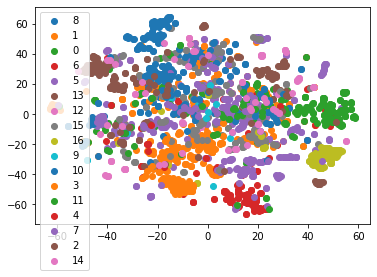

In [ ]:
G = nx.read_edgelist('Wiki_edgelist.txt',
                        create_using = nx.DiGraph(), nodetype = None, data = [('weight', int)])
model = Node2Vec(G, walk_length=10, num_walks=80,
                    p=0.25, q=4, workers=1, use_rejection_sampling=0)
model.train(window_size = 5, iter = 3)
embeddings = model.get_embeddings()

evaluate_embeddings(embeddings)
plot_embeddings(embeddings)

## Scenario - Flight

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)


In [ ]:
class Classifier(object):
    
    def __init__(self, embeddings, clf):
        self.embeddings = embeddings
        self.clf = TopKRanker(clf)
        self.binarizer = MultiLabelBinarizer(sparse_output=True)

    def train(self, X, Y, Y_all):
        self.binarizer.fit(Y_all)
        X_train = [self.embeddings[x] for x in X]
        Y = self.binarizer.transform(Y)
        self.clf.fit(X_train, Y)

    def evaluate(self, X, Y):
        top_k_list = [len(l) for l in Y]
        Y_ = self.predict(X, top_k_list)
        Y = self.binarizer.transform(Y)
        averages = ["micro", "macro", "samples", "weighted"]
        results = {}
        for average in averages:
            results[average] = f1_score(Y, Y_, average=average)
        results['acc'] = accuracy_score(Y,Y_)
        print('-------------------')
        print(results)
        return results
        print('-------------------')

    def predict(self, X, top_k_list):
        X_ = np.asarray([self.embeddings[x] for x in X])
        Y = self.clf.predict(X_, top_k_list=top_k_list)
        return Y

    def split_train_evaluate(self, X, Y, train_precent, seed=0):
        state = np.random.get_state()

        training_size = int(train_precent * len(X))
        np.random.seed(seed)
        shuffle_indices = np.random.permutation(np.arange(len(X)))
        X_train = [X[shuffle_indices[i]] for i in range(training_size)]
        Y_train = [Y[shuffle_indices[i]] for i in range(training_size)]
        X_test = [X[shuffle_indices[i]] for i in range(training_size, len(X))]
        Y_test = [Y[shuffle_indices[i]] for i in range(training_size, len(X))]

        self.train(X_train, Y_train, Y)
        np.random.set_state(state)
        return self.evaluate(X_test, Y_test)

In [ ]:
def read_node_label(filename, skip_head=False):
    fin = open(filename, 'r')
    X = []
    Y = []
    while 1:
        if skip_head:
            fin.readline()
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        X.append(vec[0])
        Y.append(vec[1:])
    fin.close()
    return X, Y

In [ ]:
!wget -q --show-progress https://raw.githubusercontent.com/shenweichen/GraphEmbedding/master/data/flight/labels-brazil-airports.txt
!wget -q --show-progress https://raw.githubusercontent.com/shenweichen/GraphEmbedding/master/data/flight/brazil-airports.edgelist

labels-brazil-airpo 100%[===================>]     687  --.-KB/s    in 0s      
brazil-airports.edg 100%[===================>]   5.91K  --.-KB/s    in 0s      


In [ ]:
def evaluate_embeddings(embeddings):
    X, Y = read_node_label('labels-brazil-airports.txt',skip_head=True)
    tr_frac = 0.8
    print("Training classifier using {:.2f}% nodes...".format(
        tr_frac * 100))
    clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
    clf.split_train_evaluate(X, Y, tr_frac)

In [ ]:
def plot_embeddings(embeddings,):
    X, Y = read_node_label('labels-brazil-airports.txt',skip_head=True)
    emb_list = []
    for k in X:
        emb_list.append(embeddings[k])
    emb_list = np.array(emb_list)
    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)
    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i][0], [])
        color_idx[Y[i][0]].append(i)
    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)  # c=node_colors)
    plt.legend()
    plt.show()

Preprocess transition probs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'micro': 0.42857142857142855, 'macro': 0.3333333333333333, 'samples': 0.42857142857142855, 'weighted': 0.2857142857142857, 'acc': 0.42857142857142855}


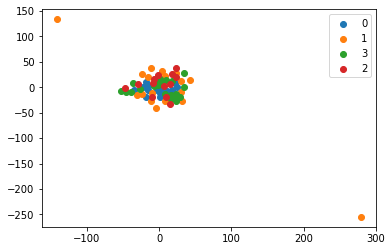

In [ ]:
G = nx.read_edgelist('brazil-airports.edgelist', create_using=nx.DiGraph(), nodetype=None,
                        data=[('weight', int)])

model = Node2Vec(G, 10, 80, workers=1, p=0.25, q=2, use_rejection_sampling=0)
model.train()
embeddings = model.get_embeddings()

evaluate_embeddings(embeddings)
plot_embeddings(embeddings)